第一階段，只針對一筆資料內做判斷，總共只有5個function:

1. CompanyTaxIDNumber_edit (string)
    * CompanyTaxIDNumber
2. InvoiceNumber_edit (string)
    * InvoiceNumber
3. PrefixTwoLetters_edit (string)
    * PrefixTwoLetters
4. SalesAmount_edit (int)
    * SalesTax
    * SalesTotalAmount
5. DayMonthYear_edit (string)
    * InvoiceDay
    * InvoiceMonth
    * InvoiceYear
    
** 注意回傳型態 **

In [1]:
import re
import math
import json

In [47]:
sample_string = """{
  "gt_parse": {
    "Abstract": "汽車材料 一批 33130",
    "BuyerTaxIDNumber": "12361788",
    "CompanyAddress": "高雄市三民區鼎新路85號",
    "CompanyName": "雄振企業有限公司",
    "CompanyTaxIDNumber": "13182854",
    "Doc_class": "triple_receipt",
    "InvoiceDay": "30",
    "InvoiceMonth": "05",
    "InvoiceNumber": "57191411",
    "InvoiceYear": "112",
    "PhoneNumber": "07-3108816",
    "PrefixTwoLetters": "MY",
    "Rationale": "統一發票(三聯式)",
    "SalesTax": "1,657",
    "SalesTotalAmount": "33,130",
    "TotalAmount": "34,787"
  }
}
"""

input_string = json.loads(sample_string)
input_string['gt_parse']['doc_class'] = "triple_invoice"
print(type(input_string), input_string['gt_parse']['doc_class'])

<class 'dict'> triple_invoice


In [50]:
import json, re
from typing import Any, Dict, Tuple, Mapping, Optional

def _extract_json(s: str) -> Dict[str, Any]:
    start = s.find("{"); end = s.rfind("}")
    if start == -1 or end == -1 or end < start:
        raise ValueError("找不到可解析的 JSON 內容")
    return json.loads(s[start:end+1])

def _canonical_key_map(d: Dict[str, Any]) -> Dict[str, str]:
    # 建立不分大小寫的鍵名映射：lower(key) -> 原鍵名
    return {k.lower(): k for k in d.keys()}

def _get_ci(d: Dict[str, Any], key: str):
    # 不分大小寫取值；找不到返回 None
    if key in d: return d[key]
    lk = key.lower()
    for k in d.keys():
        if k.lower() == lk:
            return d[k]
    return None

def _is_none(x: Any) -> bool: return x is None
def _is_nonempty_str(x: Any) -> bool: return isinstance(x, str) and len(x.strip()) > 0
def _re_match(pattern: str, x: Any) -> bool:
    if x is None: return True          # 非必填且 None 視為 OK；是否必填由 required 控制
    if not isinstance(x, str): return False
    return re.fullmatch(pattern, x.strip()) is not None

def _amount_parse_and_normalize_int_str(x: Any) -> Optional[str]:
    """允許千分位與 .00；回傳正規化整數字串，否則 None。"""
    if not isinstance(x, str) or not x.strip():
        return None
    s = x.strip()
    # 允許 "123456", "1,234,567", "1,234,567.00"
    if re.fullmatch(r"\d{1,3}(,\d{3})*(?:\.00)?", s):
        s_no_comma = s.replace(",", "")
        if s_no_comma.endswith(".00"):
            s_no_comma = s_no_comma[:-3]
        try:
            return str(int(s_no_comma))
        except ValueError:
            return None
    # 允許無逗號但帶 .00
    if re.fullmatch(r"\d+(?:\.00)?", s):
        if s.endswith(".00"):
            s = s[:-3]
        try:
            return str(int(s))
        except ValueError:
            return None
    return None

def _normalize_year_to_gregorian(y: Any) -> Optional[str]:
    """2~3 碼視為民國年 +1911；4 碼視為西元年；其餘回 None。"""
    if not isinstance(y, str) or not y.strip() or not y.strip().isdigit():
        return None
    s = y.strip()
    if len(s) in (2, 3):  # 民國年
        return str(int(s) + 1911)
    if len(s) == 4:       # 西元年
        return s
    return None


def _strip_leading_zero_num_str(x: Any) -> Optional[str]:
    """將 '09' -> '9'；若非數字字串則回 None。"""
    if not isinstance(x, str) or not x.strip():
        return None
    s = x.strip()
    if not re.fullmatch(r"\d+", s):
        return None
    try:
        return str(int(s))
    except ValueError:
        return None

PAT_MM = r"(0?[1-9]|1[0-2])"
PAT_DD = r"(0?[1-9]|[12]\d|3[01])"

def check_compliance(
    data_or_str: Any,
    required_fields: Optional[Tuple[str, ...]] = None,
    required_fields_by_doc_class: Optional[Mapping[str, Tuple[str, ...]]] = None,
    only_required_and_rules: bool = True,
    emit_info: bool = True,  # 若要加上 @info，可設 True
    emit_normalized: bool = False,                  # ★ 會輸出 @normalized:*（三個金額欄位）
    return_normalized_object: bool = True,        # ★ 回傳 (結果, 正規化後物件)
) -> Dict[str, bool]:
    # 1) 解析
    if isinstance(data_or_str, str):
        obj = _extract_json(data_or_str)
    elif isinstance(data_or_str, dict):
        obj = data_or_str
    else:
        raise TypeError("只接受 dict 或 str (JSON)")

    # 2) 取出扁平的 gt_parse（若不在 gt_parse，則視為已是扁平）
    root = obj.get("gt_parse", obj)
    keymap = _canonical_key_map(root)
    # 支援 Doc_class / doc_class；Rationale / rationale
    doc_class_key = keymap.get("doc_class", "Doc_class" if "Doc_class" in root else "doc_class")
    rationale_key = keymap.get("rationale", "Rationale" if "Rationale" in root else "rationale")
    doc_class = _get_ci(root, doc_class_key)

    # 3) 欄位格式規則（扁平版）
    rules = {
        "PrefixTwoLetters":    lambda v: _re_match(r"[A-Z]{2}", v),
        "InvoiceNumber":       lambda v: _re_match(r"\d{8}", v),
        "InvoiceYear":         lambda v: _re_match(r"(\d{2,3}|\d{4})", v),
        "InvoiceMonth":        lambda v: _re_match(r"(0?[1-9]|1[0-2])", v),
        "InvoiceDay":          lambda v: _re_match(r"(0?[1-9]|[12]\d|3[01])", v),
        "BuyerName":           lambda v: True if v is None else _is_nonempty_str(v),
        "BuyerTaxIDNumber":    lambda v: True if v is None else _re_match(r"\d{8}", v),
        "CompanyName":         lambda v: True if v is None else _is_nonempty_str(v),
        "CompanyAddress":      lambda v: True if v is None else _is_nonempty_str(v),
        "CompanyTaxIDNumber":  lambda v: True if v is None else _re_match(r"\d{8}", v),
        "PhoneNumber":         lambda v: True if v is None else _re_match(r"[0-9()+\- ]{7,}", v),
        "Abstract":            lambda v: True if v is None else _is_nonempty_str(v),
        "SalesTotalAmount":    lambda v: (_amount_parse_and_normalize_int_str(v) is not None),
        "SalesTax":            lambda v: (_amount_parse_and_normalize_int_str(v) is not None),
        "TotalAmount":         lambda v: (_amount_parse_and_normalize_int_str(v) is not None),
        # meta
        doc_class_key:         lambda v: _is_nonempty_str(v) if v is not None else True,
        rationale_key:         lambda v: True if v is None else _is_nonempty_str(v),
    }

    # 4) 平面值（用輸入的實際鍵名；找不到就是 None）
    values = { k: root.get(k) for k in [
        "PrefixTwoLetters","InvoiceNumber","InvoiceYear","InvoiceMonth","InvoiceDay",
        "BuyerName","BuyerTaxIDNumber","CompanyName","CompanyAddress","CompanyTaxIDNumber",
        "PhoneNumber","Abstract","SalesTotalAmount","SalesTax","TotalAmount",
    ]}
    values[doc_class_key] = doc_class
    values[rationale_key] = _get_ci(root, rationale_key)

    # 5) 必填欄位（扁平版；可依需求調整）
    default_required = required_fields or (
        "PrefixTwoLetters","InvoiceNumber","SalesTotalAmount","SalesTax","TotalAmount",
    )
    per_class_required = required_fields_by_doc_class or {
        "triple_invoice": (
            "PrefixTwoLetters","InvoiceNumber", "BuyerTaxIDNumber",
            "InvoiceYear","InvoiceMonth","InvoiceDay", "Abstract",
            "SalesTotalAmount","SalesTax","TotalAmount", "CompanyTaxIDNumber",
        ),
        "triple_receipt": (
            "PrefixTwoLetters","InvoiceNumber", "CompanyTaxIDNumber",
            "InvoiceYear","InvoiceMonth","InvoiceDay", "BuyerTaxIDNumber",
            "Abstract",
            "SalesTotalAmount","SalesTax","TotalAmount",
        ),
    }
    active_required = per_class_required.get(str(doc_class), default_required)

    # 基本 + 必填
    full_result: Dict[str, bool] = {}
    for key, val in values.items():
        validator = rules.get(key, lambda v: True)
        ok = validator(val)
        if ok and key in active_required:
            ok = not _is_none(val) and (not isinstance(val, str) or len(val.strip()) > 0)
        full_result[key] = bool(ok)

    # 合計規則：以正規化後數值進行
    def _to_int_from_amount(x: Any) -> Optional[int]:
        norm = _amount_parse_and_normalize_int_str(x)
        if norm is not None:
            return int(norm)
        if isinstance(x, str) and re.fullmatch(r"\d+", x or ""):
            return int(x)
        return None

    st = _to_int_from_amount(values.get("SalesTotalAmount"))
    tax = _to_int_from_amount(values.get("SalesTax"))
    total = _to_int_from_amount(values.get("TotalAmount"))
    if None not in (st, tax, total):
        full_result["@rule:TotalAmount_equals_SalesTotal_plus_SalesTax"] = (st + tax == total)

    # 正規化輸出與物件（依 doc_class 組出「固定欄位 + 固定順序」）
    # 1) 先準備各欄位的正規化值
    st_norm = _amount_parse_and_normalize_int_str(values.get("SalesTotalAmount"))
    tax_norm = _amount_parse_and_normalize_int_str(values.get("SalesTax"))
    total_norm = _amount_parse_and_normalize_int_str(values.get("TotalAmount"))
    year_norm = _normalize_year_to_gregorian(values.get("InvoiceYear"))
    mm_norm = _strip_leading_zero_num_str(values.get("InvoiceMonth")) or values.get("InvoiceMonth")
    dd_norm = _strip_leading_zero_num_str(values.get("InvoiceDay")) or values.get("InvoiceDay")

    # 2) 建立以固定順序輸出的 gt_parse
    if str(doc_class) == "triple_receipt":
        normalized_gt_parse = {
            "Doc_class": "triple_receipt",
            "Rationale": _get_ci(root, "Rationale"),
            "PrefixTwoLetters": _get_ci(root, "PrefixTwoLetters"),
            "InvoiceNumber": _get_ci(root, "InvoiceNumber"),
            "CompanyName": _get_ci(root, "CompanyName"),
            "PhoneNumber": _get_ci(root, "PhoneNumber"),
            "CompanyTaxIDNumber": _get_ci(root, "CompanyTaxIDNumber"),
            "CompanyAddress": _get_ci(root, "CompanyAddress"),
            "InvoiceYear": _get_ci(root, "InvoiceYear"), # year_norm
            "InvoiceMonth": mm_norm,
            "InvoiceDay": dd_norm,
            "BuyerTaxIDNumber": _get_ci(root, "BuyerTaxIDNumber"),
            "BuyerName": _get_ci(root, "BuyerName"),
            "Abstract": _get_ci(root, "Abstract"),
            "SalesTotalAmount": st_norm if st_norm is not None else _get_ci(root, "SalesTotalAmount"),
            "SalesTax": tax_norm if tax_norm is not None else _get_ci(root, "SalesTax"),
            "TotalAmount": total_norm if total_norm is not None else _get_ci(root, "TotalAmount"),
        }
    else:  # 預設視為 triple_invoice（或其他類型也用這個順序以符合需求）
        normalized_gt_parse = {
            "Doc_class": "triple_invoice",
            "Rationale": _get_ci(root, "Rationale"),
            "PrefixTwoLetters": _get_ci(root, "PrefixTwoLetters"),
            "InvoiceNumber": _get_ci(root, "InvoiceNumber"),
            "BuyerName": _get_ci(root, "BuyerName"),
            "BuyerTaxIDNumber": _get_ci(root, "BuyerTaxIDNumber"),
            "InvoiceYear": _get_ci(root, "InvoiceYear"), # year_norm
            "InvoiceMonth": mm_norm,
            "InvoiceDay": dd_norm,
            "Abstract": _get_ci(root, "Abstract"),
            "SalesTotalAmount": st_norm if st_norm is not None else _get_ci(root, "SalesTotalAmount"),
            "SalesTax": tax_norm if tax_norm is not None else _get_ci(root, "SalesTax"),
            "TotalAmount": total_norm if total_norm is not None else _get_ci(root, "TotalAmount"),
            "CompanyName": _get_ci(root, "CompanyName"),
            "CompanyTaxIDNumber": _get_ci(root, "CompanyTaxIDNumber"),
            "PhoneNumber": _get_ci(root, "PhoneNumber"),
            "CompanyAddress": _get_ci(root, "CompanyAddress"),
        }

    normalized_obj = {"gt_parse": normalized_gt_parse}

    # 3) 在結果中標出三個金額欄位的正規化值（如有）
    if emit_normalized:
        if year_norm is not None:  full_result["@normalized:InvoiceYear"] = year_norm
        if mm_norm is not None: full_result["@normalized:InvoiceMonth"] = mm_norm
        if dd_norm is not None:   full_result["@normalized:InvoiceDay"] = dd_norm
        if st_norm is not None:    full_result["@normalized:SalesTotalAmount"] = st_norm
        if tax_norm is not None:   full_result["@normalized:SalesTax"] = tax_norm
        if total_norm is not None: full_result["@normalized:TotalAmount"] = total_norm

    # 只輸出必填 + 規則 + 正規化資訊
    if only_required_and_rules:
        filtered = {k: v for k, v in full_result.items()
                    if k in active_required or k.startswith("@rule:") or k.startswith("@normalized:") or (emit_info and k.startswith("@info:"))}
    else:
        filtered = full_result

    return (filtered, normalized_obj) if return_normalized_object else filtered


In [51]:
compliance, edit_string = check_compliance(input_string)
print(type(compliance))
print(json.dumps(compliance, ensure_ascii=False, indent=2))
print(json.dumps(edit_string, ensure_ascii=False, indent=2))

<class 'dict'>
{
  "PrefixTwoLetters": true,
  "InvoiceNumber": true,
  "InvoiceYear": true,
  "InvoiceMonth": true,
  "InvoiceDay": true,
  "BuyerTaxIDNumber": true,
  "CompanyTaxIDNumber": true,
  "Abstract": true,
  "SalesTotalAmount": true,
  "SalesTax": true,
  "TotalAmount": true,
  "@rule:TotalAmount_equals_SalesTotal_plus_SalesTax": true
}
{
  "gt_parse": {
    "Doc_class": "triple_invoice",
    "Rationale": "統一發票(三聯式)",
    "PrefixTwoLetters": "MY",
    "InvoiceNumber": "57191411",
    "BuyerName": null,
    "BuyerTaxIDNumber": "12361788",
    "InvoiceYear": "112",
    "InvoiceMonth": "5",
    "InvoiceDay": "30",
    "Abstract": "汽車材料 一批 33130",
    "SalesTotalAmount": "33130",
    "SalesTax": "1657",
    "TotalAmount": "34787",
    "CompanyName": "雄振企業有限公司",
    "CompanyTaxIDNumber": "13182854",
    "PhoneNumber": "07-3108816",
    "CompanyAddress": "高雄市三民區鼎新路85號"
  }
}


In [ ]:
import os
import json
from tqdm import tqdm
from collections import OrderedDict

# ====== 你可以調整這裡 ======
doc_class = "triple_invoice"   # "triple_receipt" 或 "triple_invoice"
root_dir = os.path.join("C:/Users/user/pythonproject/AllDataset/VAT-OCR", doc_class)
mode = 'train'                  # 只比對 train 與 train_new
old_dir = os.path.join(root_dir, 'label', mode)          # 舊標記
new_dir = os.path.join(root_dir, 'label', f'{mode}_new') # 新標記

# ★ 不比對這些欄位（早期結構常缺）
IGNORE_FIELDS = {"BuyerTaxIDNumber", "Abstract", "TotalAmount"}
# ===========================

def _safe_get(d, path):
    cur = d
    for p in path.split('.'):
        if not isinstance(cur, dict) or p not in cur:
            return None
        cur = cur[p]
    return cur

def _first_non_empty(d, candidates):
    for path in candidates:
        v = _safe_get(d, path)
        if v is None:
            continue
        if isinstance(v, str):
            if v.strip() != "":
                return v
        else:
            return str(v)
    return ""

def _get_gt_obj(payload):
    if not isinstance(payload, dict):
        return {}
    if "gt_parse" in payload and isinstance(payload["gt_parse"], dict):
        return payload["gt_parse"]
    return payload

# ---------- 正規化工具（與你前面邏輯一致） ----------
def _amount_parse_and_normalize_int_str(x):
    """允許 '1,657.00' / '1,657' / '1657' → '1657'；失敗回 None。"""
    if not isinstance(x, str) or not x.strip():
        return None
    s = x.strip()
    import re
    if re.fullmatch(r"\d{1,3}(,\d{3})*(?:\.00)?", s):
        s_no_comma = s.replace(",", "")
        if s_no_comma.endswith(".00"):
            s_no_comma = s_no_comma[:-3]
        try:
            return str(int(s_no_comma))
        except ValueError:
            return None
    if re.fullmatch(r"\d+(?:\.00)?", s):
        if s.endswith(".00"):
            s = s[:-3]
        try:
            return str(int(s))
        except ValueError:
            return None
    return None

def _normalize_year_to_gregorian(y):
    """2~3 碼視為民國年 +1911；4 碼視為西元；其他回 None。"""
    if not isinstance(y, str) or not y.strip() or not y.strip().isdigit():
        return None
    s = y.strip()
    if len(s) in (2, 3):
        return str(int(s) + 1911)
    if len(s) == 4:
        return s
    return None

def _strip_leading_zero_num(s):
    """去前導 0（'05'→'5'）；非純數字回 None。"""
    if not isinstance(s, str) or not s.strip() or not s.strip().isdigit():
        return None
    return str(int(s.strip()))

def _normalize_flat(flat: OrderedDict, doc_class: str) -> OrderedDict:
    """對抽出的扁平欄位做正規化（年份/月份/日期/三金額）。"""
    out = OrderedDict(flat)  # copy 保序
    # 年份
    yn = _normalize_year_to_gregorian(out.get("InvoiceYear", ""))
    if yn is not None:
        out["InvoiceYear"] = yn
    # 月份/日期
    mn = _strip_leading_zero_num(out.get("InvoiceMonth", ""))
    dn = _strip_leading_zero_num(out.get("InvoiceDay", ""))
    if mn is not None:
        out["InvoiceMonth"] = mn
    if dn is not None:
        out["InvoiceDay"] = dn
    # 金額
    for k in ("SalesTotalAmount", "SalesTax", "TotalAmount"):
        an = _amount_parse_and_normalize_int_str(out.get(k, ""))
        if an is not None:
            out[k] = an
    return out

# ---------- 萃取欄位 ----------
def extract_old_flat(old_json: dict, doc_class: str) -> OrderedDict:
    d = old_json or {}
    if doc_class == "triple_receipt":
        keys_order = [
            "Doc_class","PrefixTwoLetters","InvoiceNumber","CompanyTaxIDNumber",
            "InvoiceYear","InvoiceMonth","InvoiceDay","BuyerTaxIDNumber",
            "Abstract","SalesTotalAmount","SalesTax","TotalAmount",
        ]
        out = OrderedDict()
        out["Doc_class"]          = _first_non_empty(d, ["gt_parse.Doc_class","gt_parse.doc_class","doc_class"]) or "triple_receipt"
        out["PrefixTwoLetters"]   = _first_non_empty(d, ["header.PrefixTwoLetters","gt_parse.PrefixTwoLetters","PrefixTwoLetters"])
        out["InvoiceNumber"]      = _first_non_empty(d, ["header.InvoiceNumber","gt_parse.InvoiceNumber","InvoiceNumber"])
        out["CompanyTaxIDNumber"] = _first_non_empty(d, ["body.CompanyTaxIDNumber","tail.CompanyTaxIDNumber","gt_parse.CompanyTaxIDNumber","CompanyTaxIDNumber"])
        out["InvoiceYear"]        = _first_non_empty(d, ["body.InvoiceYear","header.InvoiceYear","gt_parse.InvoiceYear","InvoiceYear"])
        out["InvoiceMonth"]       = _first_non_empty(d, ["body.InvoiceMonth","header.InvoiceMonth","gt_parse.InvoiceMonth","InvoiceMonth"])
        out["InvoiceDay"]         = _first_non_empty(d, ["body.InvoiceDay","header.InvoiceDay","gt_parse.InvoiceDay","InvoiceDay"])
        out["BuyerTaxIDNumber"]   = _first_non_empty(d, ["body.BuyerTaxIDNumber","gt_parse.BuyerTaxIDNumber","BuyerTaxIDNumber"])
        out["Abstract"]           = _first_non_empty(d, ["body.Abstract","gt_parse.Abstract","Abstract"])
        out["SalesTotalAmount"]   = _first_non_empty(d, ["tail.SalesTotalAmount","gt_parse.SalesTotalAmount","SalesTotalAmount"])
        out["SalesTax"]           = _first_non_empty(d, ["tail.SalesTax","gt_parse.SalesTax","SalesTax"])
        out["TotalAmount"]        = _first_non_empty(d, ["tail.TotalAmount","gt_parse.TotalAmount","TotalAmount"])
        return OrderedDict((k, out.get(k, "")) for k in keys_order)

    elif doc_class == "triple_invoice":
        keys_order = [
            "Doc_class","PrefixTwoLetters","InvoiceNumber","BuyerTaxIDNumber",
            "InvoiceYear","InvoiceMonth","InvoiceDay","Abstract",
            "SalesTotalAmount","SalesTax","TotalAmount","CompanyTaxIDNumber",
        ]
        out = OrderedDict()
        out["Doc_class"]          = _first_non_empty(d, ["gt_parse.Doc_class","gt_parse.doc_class","doc_class"]) or "triple_invoice"
        out["PrefixTwoLetters"]   = _first_non_empty(d, ["header.PrefixTwoLetters","gt_parse.PrefixTwoLetters","PrefixTwoLetters"])
        out["InvoiceNumber"]      = _first_non_empty(d, ["header.InvoiceNumber","gt_parse.InvoiceNumber","InvoiceNumber"])
        out["BuyerTaxIDNumber"]   = _first_non_empty(d, ["body.BuyerTaxIDNumber","gt_parse.BuyerTaxIDNumber","BuyerTaxIDNumber"])
        out["InvoiceYear"]        = _first_non_empty(d, ["body.InvoiceYear","header.InvoiceYear","gt_parse.InvoiceYear","InvoiceYear"])
        out["InvoiceMonth"]       = _first_non_empty(d, ["body.InvoiceMonth","header.InvoiceMonth","gt_parse.InvoiceMonth","InvoiceMonth"])
        out["InvoiceDay"]         = _first_non_empty(d, ["body.InvoiceDay","header.InvoiceDay","gt_parse.InvoiceDay","InvoiceDay"])
        out["Abstract"]           = _first_non_empty(d, ["body.Abstract","gt_parse.Abstract","Abstract"])
        out["SalesTotalAmount"]   = _first_non_empty(d, ["tail.SalesTotalAmount","gt_parse.SalesTotalAmount","SalesTotalAmount"])
        out["SalesTax"]           = _first_non_empty(d, ["tail.SalesTax","gt_parse.SalesTax","SalesTax"])
        out["TotalAmount"]        = _first_non_empty(d, ["tail.TotalAmount","gt_parse.TotalAmount","TotalAmount"])
        out["CompanyTaxIDNumber"] = _first_non_empty(d, ["body.CompanyTaxIDNumber","tail.CompanyTaxIDNumber","gt_parse.CompanyTaxIDNumber","CompanyTaxIDNumber"])
        return OrderedDict((k, out.get(k, "")) for k in keys_order)

    else:
        raise ValueError(f"Unsupported doc_class: {doc_class}")

def extract_new_flat(new_json: dict, doc_class: str) -> OrderedDict:
    g = _get_gt_obj(new_json)
    if doc_class == "triple_receipt":
        keys_order = [
            "Doc_class","PrefixTwoLetters","InvoiceNumber","CompanyTaxIDNumber",
            "InvoiceYear","InvoiceMonth","InvoiceDay","BuyerTaxIDNumber",
            "Abstract","SalesTotalAmount","SalesTax","TotalAmount",
        ]
    elif doc_class == "triple_invoice":
        keys_order = [
            "Doc_class","PrefixTwoLetters","InvoiceNumber","BuyerTaxIDNumber",
            "InvoiceYear","InvoiceMonth","InvoiceDay","Abstract",
            "SalesTotalAmount","SalesTax","TotalAmount","CompanyTaxIDNumber",
        ]
    else:
        raise ValueError(f"Unsupported doc_class: {doc_class}")

    out = OrderedDict()
    for k in keys_order:
        v = g.get(k)
        out[k] = "" if v is None else str(v)
    return out

def diff_ordered(a: OrderedDict, b: OrderedDict, ignore_keys=None):
    """回傳所有不同欄位；ignore_keys 內的欄位不列入比較。"""
    if ignore_keys is None:
        ignore_keys = set()
    diffs = []
    for k in a.keys():
        if k in ignore_keys:
            continue
        if a.get(k, "") != b.get(k, ""):
            diffs.append((k, a.get(k, ""), b.get(k, "")))
    return diffs

# ===== 主程式 =====
if not os.path.isdir(old_dir):
    raise FileNotFoundError(f"Old label dir not found: {old_dir}")
if not os.path.isdir(new_dir):
    raise FileNotFoundError(f"New label dir not found: {new_dir}")

old_set = {f for f in os.listdir(old_dir) if f.lower().endswith(".json")}
new_set = {f for f in os.listdir(new_dir) if f.lower().endswith(".json")}
common = sorted(old_set & new_set)

print(f"Old JSONs: {len(old_set)} | New JSONs: {len(new_set)} | Common: {len(common)}")
print(f"Ignore fields in comparison: {sorted(IGNORE_FIELDS)}")

error_per_field = {}
ok_count = 0
diff_count = 0
err_files = 0

for entry in tqdm(common, desc="Comparing"):
    old_path = os.path.join(old_dir, entry)
    new_path = os.path.join(new_dir, entry)
    try:
        with open(old_path, "r", encoding="utf-8") as f:
            old_json = json.load(f)
        with open(new_path, "r", encoding="utf-8") as f:
            new_json = json.load(f)

        # 萃取 → 正規化（舊、新都做；已正規化者不受影響）
        old_flat_raw = extract_old_flat(old_json, doc_class)
        new_flat_raw = extract_new_flat(new_json, doc_class)

        old_flat = _normalize_flat(old_flat_raw, doc_class)
        new_flat = _normalize_flat(new_flat_raw, doc_class)

        diffs = diff_ordered(old_flat, new_flat, ignore_keys=IGNORE_FIELDS)
        if not diffs:
            ok_count += 1
            print(f"OK: {entry}")
        else:
            diff_count += 1
            print(f"DIFF: {entry}")
            for k, va, vb in diffs:
                print(f"  - {k}: OLD='{va}'  NEW='{vb}'")
                error_per_field[k] = error_per_field.get(k, 0) + 1

    except Exception as e:
        err_files += 1
        print(f"[ERROR] {entry}: {e}")

print("==== Summary ====")
print(f"OK files     : {ok_count}")
print(f"DIFF files   : {diff_count}")
print(f"ERROR files  : {err_files}")
if error_per_field:
    print("Field diff counts:")
    for k, cnt in error_per_field.items():
        print(f"  {k}: {cnt}")


Old JSONs: 1258 | New JSONs: 816 | Common: 816
Ignore fields in comparison: ['Abstract', 'BuyerTaxIDNumber', 'TotalAmount']


Comparing: 100%|██████████| 816/816 [00:00<00:00, 8077.18it/s]

OK: 1.json
OK: 10.json
OK: 100.json
OK: 101.json
OK: 111.json
OK: 119.json
OK: 140.json
OK: 149.json
DIFF: 164.json
  - InvoiceDay: OLD='31'  NEW='1'
  - SalesTotalAmount: OLD='211130'  NEW='11130'
  - SalesTax: OLD='10557'  NEW='1057'
DIFF: 168.json
  - InvoiceDay: OLD='31'  NEW='21'
OK: 174.json
OK: 191.json
OK: 192.json
DIFF: 202.json
  - InvoiceDay: OLD='28'  NEW='8'
OK: 234.json
DIFF: 235.json
  - InvoiceMonth: OLD='7'  NEW='3'
OK: 239.json
DIFF: 243.json
  - InvoiceDay: OLD='17'  NEW='7'
OK: 248.json
DIFF: 251.json
  - InvoiceMonth: OLD='13'  NEW='7'
  - InvoiceDay: OLD='7'  NEW='13'
DIFF: 254.json
  - InvoiceMonth: OLD='7'  NEW='3'
OK: 297.json
OK: 313.json
DIFF: 325.json
  - SalesTax: OLD='575'  NEW='525'
OK: 327.json
DIFF: 338.json
  - InvoiceMonth: OLD='09'  NEW='9'
  - InvoiceDay: OLD='07'  NEW='7'
DIFF: 352.json
  - InvoiceDay: OLD='18'  NEW='8'
OK: 380.json
OK: 40.json
OK: 409.json
OK: 413.json
OK: 420.json
OK: 423.json
DIFF: 43.json
  - InvoiceMonth: OLD='3'  NEW='7'
  - 

In [32]:
# CompanyTaxIDNumber

def CompanyTaxIDNumber_edit(number):
    # 使用正則表達式去除字串前後的非數字字符
    number = re.sub(r"[^\d]", "", number)
    if len(number)>9:
        match = re.search(r"\d{9}$", number)
        number = match.group()
    
    # 如果數字是9位，且以0結尾，去掉結尾的0
    number = re.sub(r"^(\d{8})0$", r"\1", number)
    # 如果數字是9位，且以0開頭，去掉開頭的0
    number = re.sub(r"^0(\d{8})$", r"\1", number)
    # 最後確認數字是否為8位，如果是，返回結果
    if re.fullmatch(r"\d{8}", number):
        return number
    else:
        number = number[1:0]
        return number  # 如果數字無法正確轉換為8位，返回 None 或其他適當處理

# 測試六種情況
numbers = ["*222364243*", "*22364243", "22364243*", "04346244", "04641604", "16/415499", "022072190", "359886900", "359886908"]

for number in numbers:
    normalized = CompanyTaxIDNumber_edit(number)
    if normalized:
        print(f"原數字: {number} -> 轉換後: {normalized}")
        print(type(number))
    else:
        print(f"原數字: {number} -> 無法轉換為8位數字")

原數字: *222364243* -> 無法轉換為8位數字
原數字: *22364243 -> 轉換後: 22364243
<class 'str'>
原數字: 22364243* -> 轉換後: 22364243
<class 'str'>
原數字: 04346244 -> 轉換後: 04346244
<class 'str'>
原數字: 04641604 -> 轉換後: 04641604
<class 'str'>
原數字: 16/415499 -> 轉換後: 16415499
<class 'str'>
原數字: 022072190 -> 轉換後: 02207219
<class 'str'>
原數字: 359886900 -> 轉換後: 35988690
<class 'str'>
原數字: 359886908 -> 無法轉換為8位數字


In [3]:
# InvoiceNumber

def InvoiceNumber_edit(number):
    # 使用正則表達式去除字串前後的非數字字符
    number = re.sub(r"^\D+|\D+$", "", number)
    
    if re.fullmatch(r"\d{8}", number):
        return number
    else:
        return number  # 如果數字無法正確轉換為8位，返回 None 或其他適當處理

# 測試
numbers = ["KY 53087732", "KY53087732"]

for number in numbers:
    normalized = InvoiceNumber_edit(number)
    if normalized:
        print(f"原數字: {number} -> 轉換後: {normalized}")
    else:
        print(f"原數字: {number} -> 無法轉換為8位數字")


原數字: KY 53087732 -> 轉換後: 53087732
原數字: KY53087732 -> 轉換後: 53087732


In [7]:
# PrefixTwoLetters

def PrefixTwoLetters_edit(text):
    # 使用正則表達式去除字串前後的非數字字符
    result = re.findall(r"[A-Z]", text)
    result = ''.join(result[:2])
    
    return result

# 測試
numbers = ["KY", "000KY", "KY0000", "SAAEE2"]

for number in numbers:
    normalized = PrefixTwoLetters_edit(number)
    if normalized:
        print(f"原數字: {number} -> 轉換後: {normalized}")
    else:
        print(f"原數字: {number} -> 無法轉換為8位數字")

原數字: KY -> 轉換後: KY
原數字: 000KY -> 轉換後: KY
原數字: KY0000 -> 轉換後: KY
原數字: SAAEE2 -> 轉換後: SA


In [28]:
# SalesTax & SalesTotalAmount

def SalesAmount_edit(total, tax):
    # 使用正則表達式去除所有非數字字符
    #total = int(re.sub(r"\D", "", total))
    try:
        total = int(re.sub(r"\D", "", total))
    except ValueError:
        total = 0
    try:
        tax = int(re.sub(r"\D", "", tax))
    except ValueError:
        tax = 0
    
    tax_cal = math.floor(total * 0.05 + 0.5)
    if tax == tax_cal:
        return total, tax
    else:
        if tax == 0:
            tax_cal = math.floor(total * 0.05 + 0.5)
            return total, tax_cal
        elif total == 0:
            total_cal = tax*20
            return total_cal, tax
        # 判斷是否大於100
        elif total>100:
            last_two_digits = total%100
            total_cal = tax*20
            combined_number = (total_cal//100) * 100 + last_two_digits
            return combined_number, tax
        else:
            print("i'm here")
            tax_cal = math.floor(total * 0.05 + 0.5)
            return total, tax_cal

# 測試
totals = ["141130", "33,000-", "13500", "701", "450.", "0", "1800", "2207", "zonco", "0"]  # 將數字轉換為整數
taxs   = ["7057", "1650", "625", "5", ">3", "975", "PD", "385", "1035", "638"]

for total, tax in zip(totals, taxs):
    total_cal, tax_cal = SalesAmount_edit(total, tax)
    print(f"原總額: {total}, 原稅額: {tax} -> 更正總額: {total_cal}, 更正稅額: {tax_cal}")

原總額: 141130, 原稅額: 7057 -> 更正總額: 141130, 更正稅額: 7057
原總額: 33,000-, 原稅額: 1650 -> 更正總額: 33000, 更正稅額: 1650
原總額: 13500, 原稅額: 625 -> 更正總額: 12500, 更正稅額: 625
原總額: 701, 原稅額: 5 -> 更正總額: 101, 更正稅額: 5
原總額: 450., 原稅額: >3 -> 更正總額: 50, 更正稅額: 3
原總額: 0, 原稅額: 975 -> 更正總額: 19500, 更正稅額: 975
原總額: 1800, 原稅額: PD -> 更正總額: 1800, 更正稅額: 90
原總額: 2207, 原稅額: 385 -> 更正總額: 7707, 更正稅額: 385
原總額: zonco, 原稅額: 1035 -> 更正總額: 20700, 更正稅額: 1035
原總額: 0, 原稅額: 638 -> 更正總額: 12760, 更正稅額: 638


In [6]:
def DayMonthYear_edit(day, month, year):
    day = re.sub(r"^0+", "", day)
    month = re.sub(r"^0+", "", month)
    year = re.sub(r"^0+", "", year)
    
    return day, month, year
    



In [7]:
import re

# 假設這是你要處理的包含前導零的正整數字串
text = "00012300456007000"

# 使用正則表達式去除所有的前導零
cleaned_text = re.sub(r"^0+", "", text)

print(f"處理後的數字是: {cleaned_text}")


處理後的數字是: 12300456007000


第二階段，跨data做判別
* InvoiceYear
* PrefixTwoLetters

（待續）還沒寫完

In [5]:
from collections import Counter

def add_element(element):
    global arr, counter
    arr.append(element)
    counter[element] += 1
    print(counter)
    # 找到出現最多的值
    most_common_value, most_common_count = counter.most_common(1)[0]
    
    # 將陣列中的所有值替換為出現最多的元素
    arr = [most_common_value] * len(arr)
    print(f"目前數組: {arr}")
    print(f"目前計數: {dict(counter)}")
    print(f"出現最多的元素: '{most_common_value}', 出現次數: {most_common_count}\n")


# 初始化空數組和計數器
arr = []
counter = Counter()


# 動態新增元素 (PrefixTwoLetters)
add_element("XM")
add_element("XM")
add_element("XM")
add_element("XM")
add_element("XM")
add_element("XM")
add_element("XM")
add_element("XM")
add_element("XM")
add_element("SAAEE2")
add_element("")
add_element("XM")
'''

# 動態新增元素 (InvoiceYear)
add_element("111")
add_element("111")
add_element("111")
add_element("1")
add_element("11")
add_element("111")
add_element("111")
add_element("111")
add_element("111")
add_element("111")
add_element("11")
add_element("111")
'''

Counter({'XM': 1})
目前數組: ['XM']
目前計數: {'XM': 1}
出現最多的元素: 'XM', 出現次數: 1

Counter({'XM': 2})
目前數組: ['XM', 'XM']
目前計數: {'XM': 2}
出現最多的元素: 'XM', 出現次數: 2

Counter({'XM': 3})
目前數組: ['XM', 'XM', 'XM']
目前計數: {'XM': 3}
出現最多的元素: 'XM', 出現次數: 3

Counter({'XM': 4})
目前數組: ['XM', 'XM', 'XM', 'XM']
目前計數: {'XM': 4}
出現最多的元素: 'XM', 出現次數: 4

Counter({'XM': 5})
目前數組: ['XM', 'XM', 'XM', 'XM', 'XM']
目前計數: {'XM': 5}
出現最多的元素: 'XM', 出現次數: 5

Counter({'XM': 6})
目前數組: ['XM', 'XM', 'XM', 'XM', 'XM', 'XM']
目前計數: {'XM': 6}
出現最多的元素: 'XM', 出現次數: 6

Counter({'XM': 7})
目前數組: ['XM', 'XM', 'XM', 'XM', 'XM', 'XM', 'XM']
目前計數: {'XM': 7}
出現最多的元素: 'XM', 出現次數: 7

Counter({'XM': 8})
目前數組: ['XM', 'XM', 'XM', 'XM', 'XM', 'XM', 'XM', 'XM']
目前計數: {'XM': 8}
出現最多的元素: 'XM', 出現次數: 8

Counter({'XM': 9})
目前數組: ['XM', 'XM', 'XM', 'XM', 'XM', 'XM', 'XM', 'XM', 'XM']
目前計數: {'XM': 9}
出現最多的元素: 'XM', 出現次數: 9

Counter({'XM': 9, 'SAAEE2': 1})
目前數組: ['XM', 'XM', 'XM', 'XM', 'XM', 'XM', 'XM', 'XM', 'XM', 'XM']
目前計數: {'XM': 9, 'SAAEE2': 1}
出現最多的元素:

'\n\n# 動態新增元素 (InvoiceYear)\nadd_element("111")\nadd_element("111")\nadd_element("111")\nadd_element("1")\nadd_element("11")\nadd_element("111")\nadd_element("111")\nadd_element("111")\nadd_element("111")\nadd_element("111")\nadd_element("11")\nadd_element("111")\n'

In [29]:
# Import reqiured modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.rmsprop import RMSprop  # Optimizer added
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm for progress bars
from torch.optim.lr_scheduler import StepLR

In [32]:
# Based on YOLO's mechanism we build a conv network
class SimpleYOLO(nn.Module):
    def __init__(self):
        super(SimpleYOLO, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm1 = nn.BatchNorm2d(32) # Batch the data
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4 + 10)
        self.dropout = nn.Dropout(0.5)  # Dropping off the nodes
        self.leaky_relu = nn.LeakyReLU(0.1)  # ReLU
        
    def forward(self, x):
        x = self.pool(self.leaky_relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(self.leaky_relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(self.leaky_relu(self.batch_norm3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [33]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),  # Ensure fast so no action is needed
])

# Fetch the dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}", leave=True)
    for batch_idx, (data, target) in enumerate(train_loader_tqdm):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        batch_size = data.shape[0]
        target_bbox = torch.tensor([[0.5, 0.5, 1.0, 1.0]] * batch_size).to(device)
        target_onehot = torch.eye(10, device=device)[target]  # Ensure target_onehot is on the same device
        target_combined = torch.cat((target_bbox, target_onehot), dim=1)

        output = model(data)
        loss = criterion(output, target_combined)
        loss.backward()
        optimizer.step()

        train_loader_tqdm.set_postfix(loss=loss.item(), refresh=False)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            batch_size = data.shape[0]
            target_bbox = torch.tensor([[0.5, 0.5, 1.0, 1.0]] * batch_size).to(device)
            target_onehot = torch.eye(10, device=device)[target]  # Ensure target_onehot is on the same device
            target_combined = torch.cat((target_bbox, target_onehot), dim=1)

            test_loss += criterion(output, target_combined).item()
            pred = output[:, 4:].argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleYOLO().to(device)
optimizer = RMSprop(model.parameters(), lr=0.001)  # In this scenario RMS is better than Adam
criterion = nn.MSELoss()
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

final_accuracy = 0  # To store the final accuracy after all epochs

num_epochs = 20

for epoch in range(1, num_epochs + 1):
    avg_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    accuracy = test(model, device, test_loader, criterion)
    scheduler.step(avg_loss)  # Update learning rate based on training loss
    final_accuracy = accuracy

print(f"Accuracy: {final_accuracy:.2f}%")

Epoch 20: 100%|█████████████████| 938/938 [00:59<00:00, 15.90it/s, loss=0.00238]


Accuracy: 99.47%


(10000, 28, 28)
(10000,)


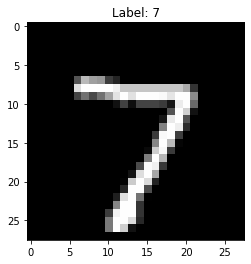

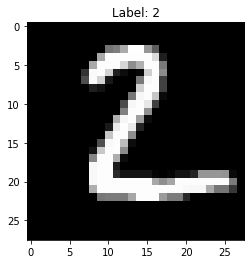

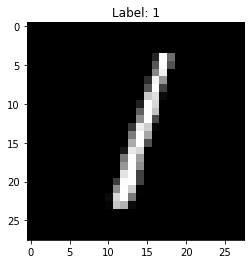

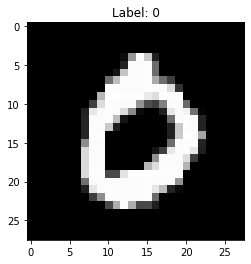

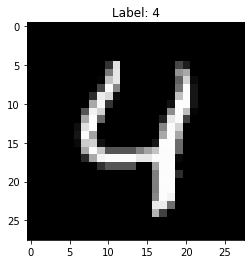

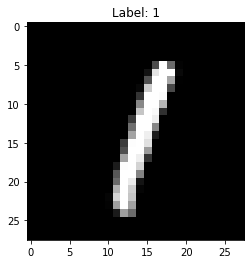

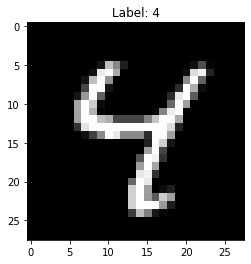

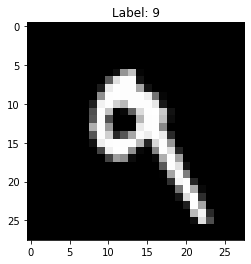

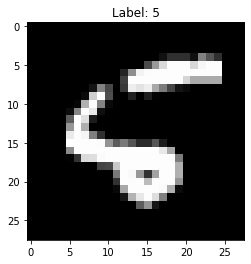

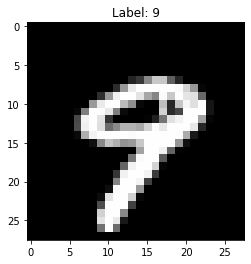

In [37]:
import struct
import numpy as np

def read_ubyte_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def read_ubyte_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

images = read_ubyte_images('./data/MNIST/raw/t10k-images-idx3-ubyte')
labels = read_ubyte_labels('./data/MNIST/raw/t10k-labels-idx1-ubyte')

print(images.shape)  # For example: (60000, 28, 28)
print(labels.shape)  # For example: (60000,)

import matplotlib.pyplot as plt

for i in range(10):
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Label: {labels[i]}')
    plt.show()


((0, 111, 36, 3), (8, 11, 72, 97), (39, 86, 365, 28), (95, 33, 55, 62), (202, 38, 22, 61), (249, 43, 48, 54), (260, 48, 5, 4), (308, 24, 79, 65))


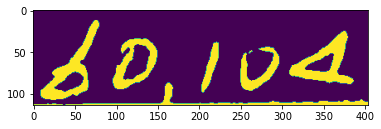

72 97
tensor([[8]])


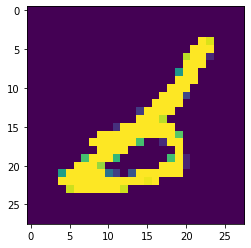

365 28
tensor([[2]])


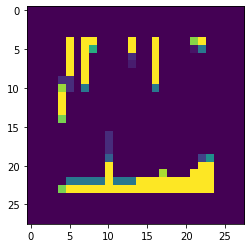

55 62
tensor([[8]])


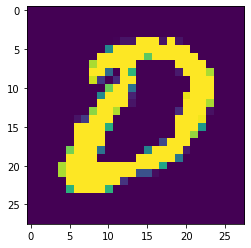

22 61
tensor([[8]])


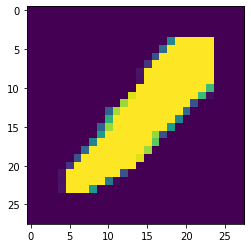

48 54
tensor([[8]])


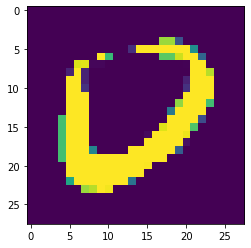

79 65
tensor([[8]])


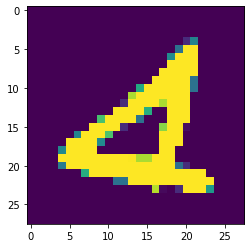

In [132]:
def sort_contours(cnts):
    boundingBoxes=[cv2.boundingRect(contour) for contour in contours]
    (cnts, boundingboxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b:b[1][0]))
    return cnts,boundingboxes

image=cv2.imread('./data/test_image4.png')
gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#_, binary_img = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
_, binary_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

edged=cv2.Canny(binary_img,100,200)
contours,heirarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contours,boundingboxes=sort_contours(contours)

print(boundingboxes)

plt.imshow(binary_img)
plt.show()

for box in boundingboxes:
    x,y,w,h=box
    if (w >= 20 and h >= 25):
        print(w, h)
        digit_img = binary_img[y:y+h,x:x+w]
        digit_img = cv2.resize(digit_img, (20, 20))
        # 計算需要填充的邊緣大小
        #padding = (6, 6, 6, 6)  # 左、右、上、下各填充6像素
        digit_img = cv2.copyMakeBorder(digit_img, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=0)

        #digit_img = cv2.resize(digit_img, (28, 28))
        digit = torch.from_numpy(digit_img).float()
        digit = digit.unsqueeze(0).unsqueeze(0)  # Now the shape is [1, 1, 28, 28]

        #print(type(digit))
        #print(digit.shape)
        output = model(digit)
        #print(output.shape)
        #print(output)
        pred = output[:, 4:].argmax(dim=1, keepdim=True)
        print(pred)
        plt.imshow(digit_img)
        plt.show()



In [107]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            print(type(data))
            print(data.shape)
            output = model(data)
            print(output.shape)
            
            batch_size = data.shape[0]
            target_bbox = torch.tensor([[0.5, 0.5, 1.0, 1.0]] * batch_size).to(device)
            target_onehot = torch.eye(10, device=device)[target]  # Ensure target_onehot is on the same device
            target_combined = torch.cat((target_bbox, target_onehot), dim=1)
            
            print(target_combined)

            test_loss += criterion(output, target_combined).item()
            pred = output[:, 4:].argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

accuracy = test(model, device, test_loader, criterion)
print(accuracy)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.

torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.000

torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.000

torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.000

torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.000

tensor([[0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
  

torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.000

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.

torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.000

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.

torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.000

torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.000

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.

torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.000

tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
  

tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
  

tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
  

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.

torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.000

tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
  

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64, 14])
tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.

tensor([[0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
  